In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

# Importing Data 

In [2]:
#Read Datasets
df_aisles = pd.read_csv('aisles.csv')
df_dept = pd.read_csv('departments.csv')
df_prod = pd.read_csv('products.csv')
df_orders = pd.read_csv('orders.csv')
df_order_prod_prior = pd.read_csv('order_products__prior.csv')
df_order_prod_train = pd.read_csv('order_products__train.csv')

In [3]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
df_dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
df_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
df_order_prod_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
df_order_prod_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
df_aisles.shape

(134, 2)

In [10]:
df_dept.shape

(21, 2)

In [11]:
df_prod.shape

(49688, 4)

In [12]:
df_orders.shape

(3421083, 7)

In [13]:
df_order_prod_prior.shape

(32434489, 4)

In [14]:
df_order_prod_train.shape

(1384617, 4)

# Merging Data 

In [15]:
product_aisle = df_prod.merge(df_aisles, left_on = 'aisle_id', right_on = 'aisle_id')
product_all = product_aisle.merge(df_dept, left_on = 'department_id', right_on = 'department_id')
product_all = product_all.drop(columns = ['aisle_id', 'department_id'])
product_all = product_all[['product_id', 'product_name', 'department','aisle']]
product_all.head()

,product_id,product_name,department,aisle
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,snacks,cookies cakes
2,102,Danish Butter Cookies,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,snacks,cookies cakes


In [16]:
df_order_prod = pd.concat([df_order_prod_prior, df_order_prod_train], axis = 0)

In [17]:
df_order_prod.shape

(33819106, 4)

In [18]:
order_products = df_order_prod.merge(product_all, left_on = 'product_id', right_on = 'product_id')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,2,33120,1,1,Organic Egg Whites,dairy eggs,eggs
1,26,33120,5,0,Organic Egg Whites,dairy eggs,eggs
2,120,33120,13,0,Organic Egg Whites,dairy eggs,eggs
3,327,33120,5,1,Organic Egg Whites,dairy eggs,eggs
4,390,33120,28,1,Organic Egg Whites,dairy eggs,eggs


In [19]:
df = order_products.merge(df_orders, left_on = 'order_id', right_on = 'order_id')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,dairy eggs,eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,produce,fresh vegetables,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,pantry,spices seasonings,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,pantry,oils vinegars,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,pantry,baking ingredients,202279,prior,3,5,9,8.0


# EDA

### Cleaning Data

In [20]:
df = df[['user_id','order_id', 'order_number','order_dow', 'order_hour_of_day', 'days_since_prior_order',
         'product_name', 'add_to_cart_order', 'reordered','department', 'aisle']]

In [21]:
df.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,add_to_cart_order,reordered,department,aisle
0,202279,2,3,5,9,8.0,Organic Egg Whites,1,1,dairy eggs,eggs
1,202279,2,3,5,9,8.0,Michigan Organic Kale,2,1,produce,fresh vegetables
2,202279,2,3,5,9,8.0,Garlic Powder,3,0,pantry,spices seasonings
3,202279,2,3,5,9,8.0,Coconut Butter,4,1,pantry,oils vinegars
4,202279,2,3,5,9,8.0,Natural Sweetener,5,0,pantry,baking ingredients


In [22]:
#Remove whitespacing 
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['user_id', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'add_to_cart_order',
       'reordered', 'department', 'aisle'],
      dtype='object')

In [23]:
df.shape

(33819106, 11)

In [24]:
df.isnull().sum()

user_id                         0
order_id                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
add_to_cart_order               0
reordered                       0
department                      0
aisle                           0
dtype: int64

In [25]:
#Remove nulls 
df.dropna(inplace = True)

In [26]:
df.isnull().sum()

user_id                   0
order_id                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
add_to_cart_order         0
reordered                 0
department                0
aisle                     0
dtype: int64

In [27]:
df.shape

(31741038, 11)

In [28]:
#Remove duplicates
df.drop_duplicates(inplace = True)

In [29]:
df.shape

(31741038, 11)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31741038 entries, 0 to 33819105
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   user_id                 int64  
 1   order_id                int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_name            object 
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department              object 
 10  aisle                   object 
dtypes: float64(1), int64(7), object(3)
memory usage: 2.8+ GB


In [31]:
#Converting weekdays from numbers to labels
df['order_dow'] = df['order_dow'].replace({0 :'Sunday', 1 : 'Monday', 2 : 'Tuesday', 3 : 'Wednesday',
                                           4 : 'Thursday', 5 : 'Friday', 6 : 'Saturday'})

### Visualization

In [32]:
#Top 10 Aisles
top_10_aisles = df['aisle'].value_counts().reset_index().head(10)
top_10_aisles.columns = ['aisle', 'frequency_count']
top_10_aisles

,aisle,frequency_count
0,fresh fruits,3576770
1,fresh vegetables,3353094
2,packaged vegetables fruits,1733391
3,yogurt,1417365
4,packaged cheese,958080
5,milk,873300
6,water seltzer sparkling water,828737
7,chips pretzels,706695
8,soy lactosefree,625431
9,bread,571400


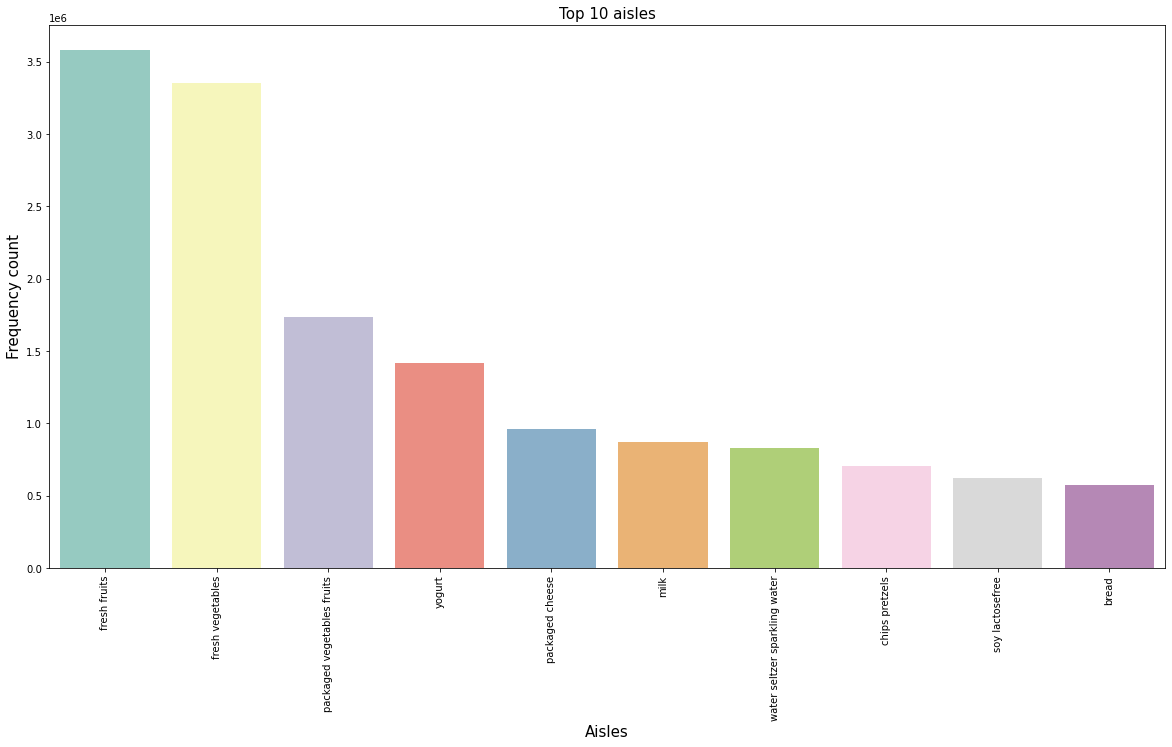

In [33]:
plt.figure(figsize = (20, 10))

sns.barplot(x = 'aisle', y = 'frequency_count', data = top_10_aisles, palette = 'Set3')

plt.title('Top 10 aisles', fontsize = 15)
plt.ylabel('Frequency count', fontsize = 15)
plt.xlabel('Aisles', fontsize = 15)
plt.xticks(rotation = 'vertical');

In [34]:
#Top 10 Sold Products
top_10_products = df['product_name'].value_counts().reset_index().head(10)
top_10_products.columns = ['product_name', 'frequency_count']
top_10_products

,product_name,frequency_count
0,Banana,461757
1,Bag of Organic Bananas,375772
2,Organic Strawberries,259113
3,Organic Baby Spinach,236757
4,Organic Hass Avocado,209771
5,Organic Avocado,169037
6,Large Lemon,152432
7,Strawberries,140785
8,Limes,138062
9,Organic Raspberries,136224


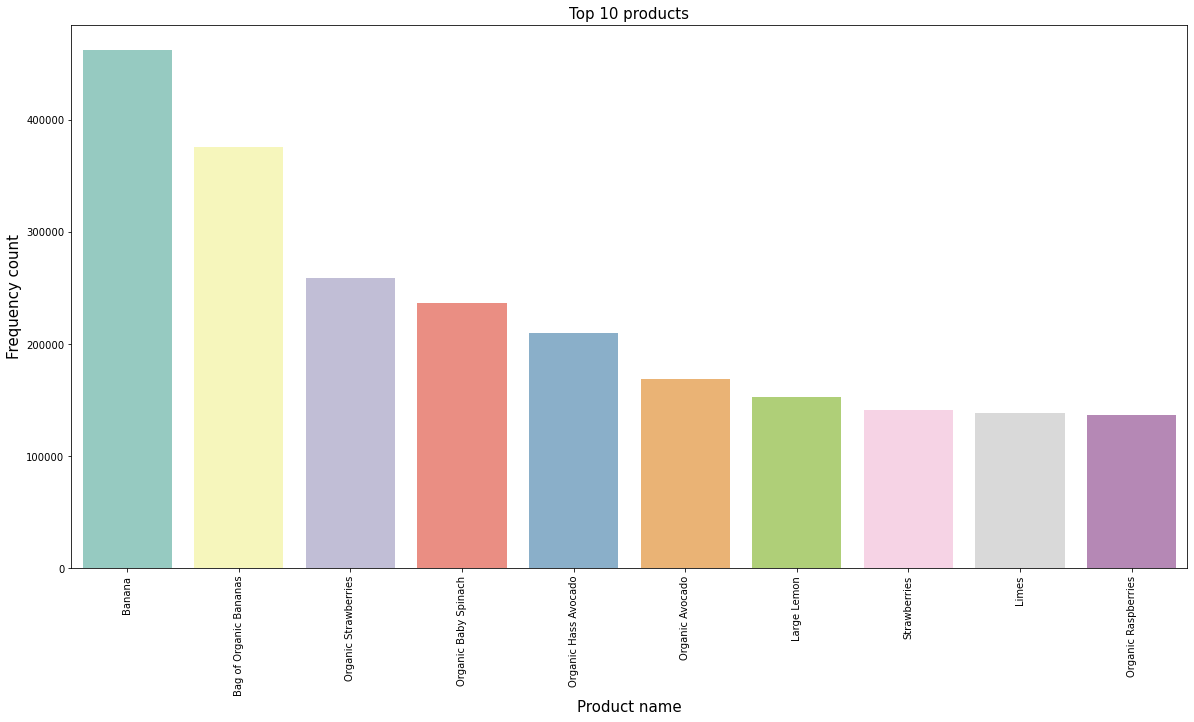

In [35]:
plt.figure(figsize = (20, 10))

sns.barplot(x = 'product_name', y = 'frequency_count', data = top_10_products, palette = 'Set3')

plt.title('Top 10 products', fontsize = 15)
plt.ylabel('Frequency count', fontsize = 15)
plt.xlabel('Product name', fontsize = 15)
plt.xticks(rotation = 'vertical');

In [36]:
#Top 10 Departments
top_10_departments = df['department'].value_counts().reset_index().head(10)
top_10_departments.columns = ['department', 'frequency_count']
top_10_departments

,department,frequency_count
0,produce,9303994
1,dairy eggs,5298037
2,snacks,2825503
3,beverages,2636557
4,frozen,2178535
5,pantry,1828551
6,bakery,1149640
7,canned goods,1041091
8,deli,1025441
9,dry goods pasta,844358


Text(0.5, 0, 'Departments')

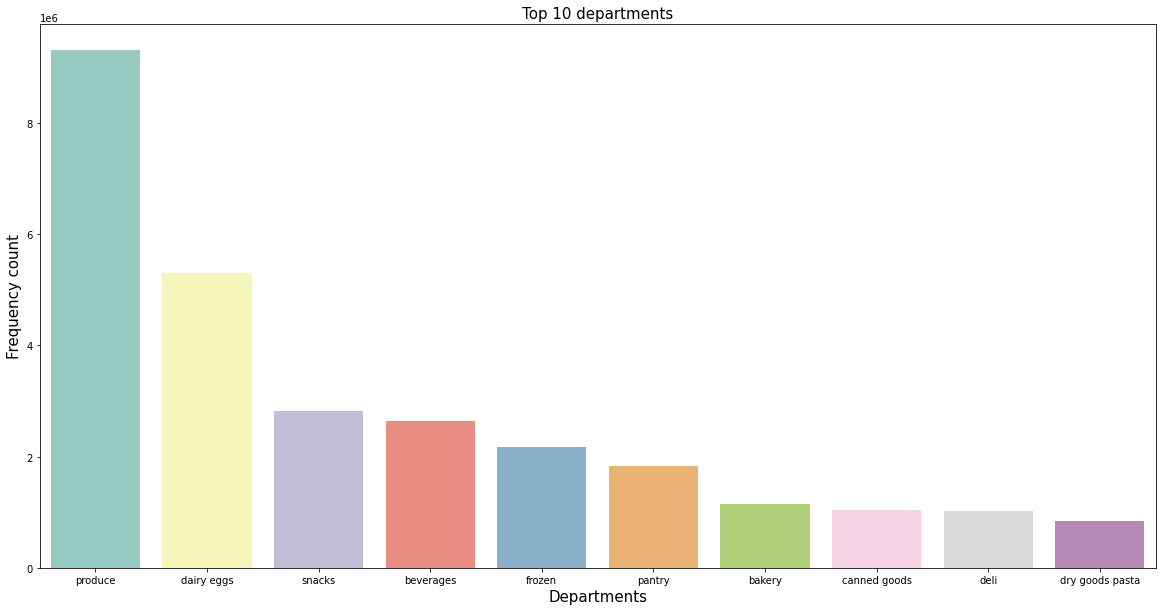

In [37]:
plt.figure(figsize = (20, 10))

sns.barplot(x = 'department', y = 'frequency_count', data = top_10_departments, palette = 'Set3')

plt.title('Top 10 departments', fontsize = 15)
plt.ylabel('Frequency count', fontsize = 15)
plt.xlabel('Departments', fontsize = 15)

Text(0.5, 0, 'Day of week')

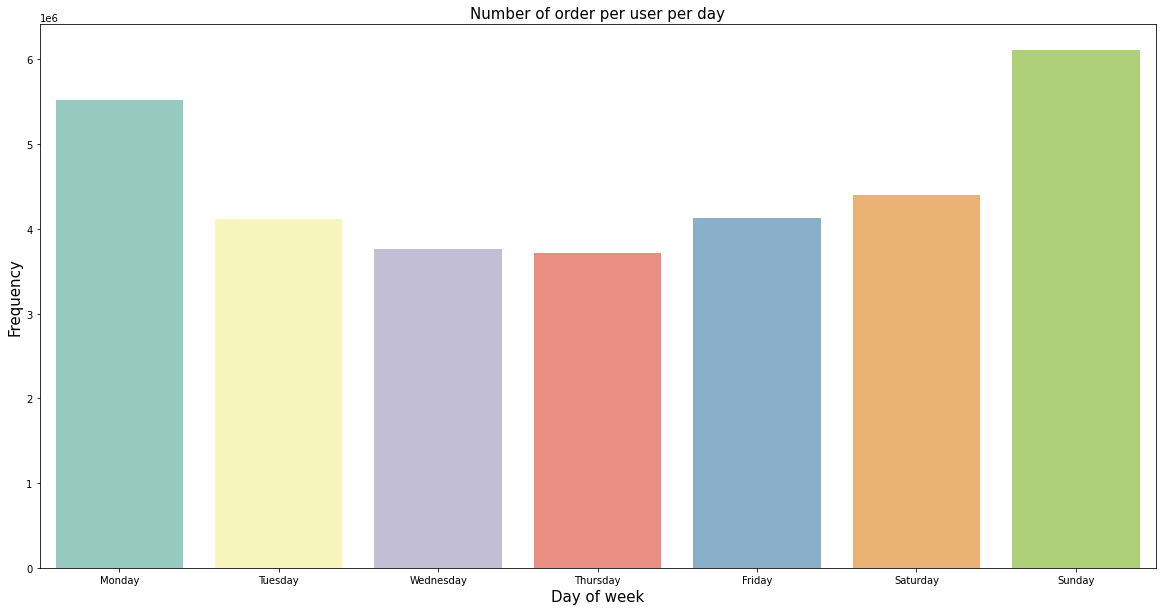

In [38]:
plt.figure(figsize = (20, 10))

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

sns.countplot(x = 'order_dow', data = df, order = days, palette = 'Set3')
plt.title('Number of order per user per day', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Day of week', fontsize = 15)

C:\Users\Manal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Hours of Order')

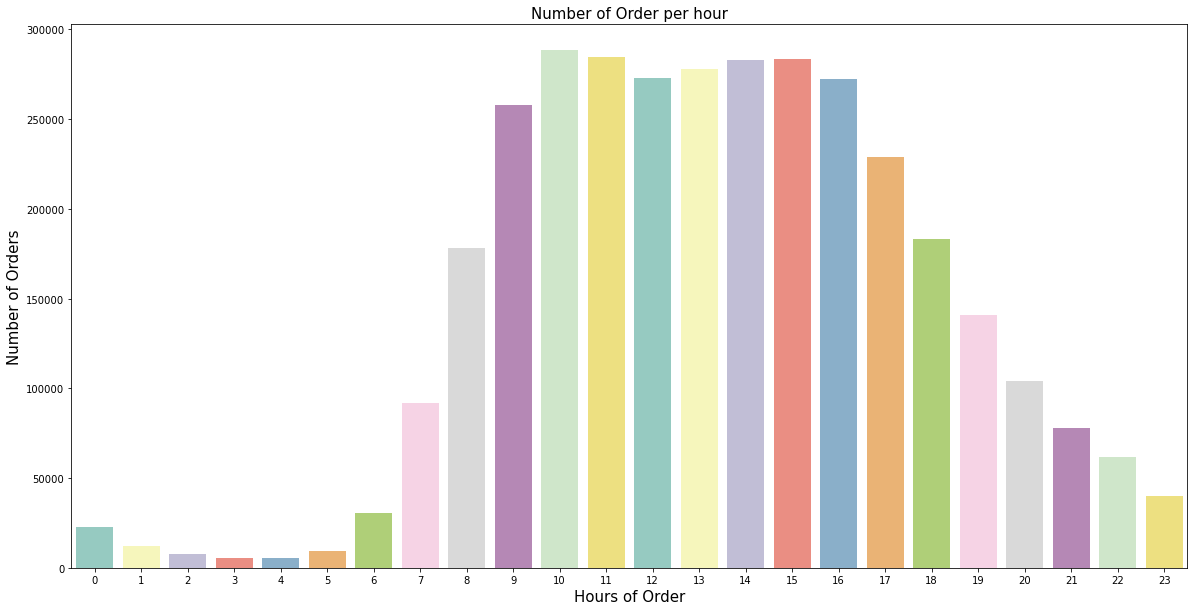

In [39]:
plt.figure(figsize = (20, 10))

hours = df_orders.groupby('order_id')['order_hour_of_day'].aggregate('sum').reset_index()
hours = hours.order_hour_of_day.value_counts()

sns.barplot(hours.index, hours.values, palette = 'Set3')
plt.title('Number of Order per hour', fontsize = 15)
plt.ylabel('Number of Orders', fontsize = 15)
plt.xlabel('Hours of Order', fontsize = 15)

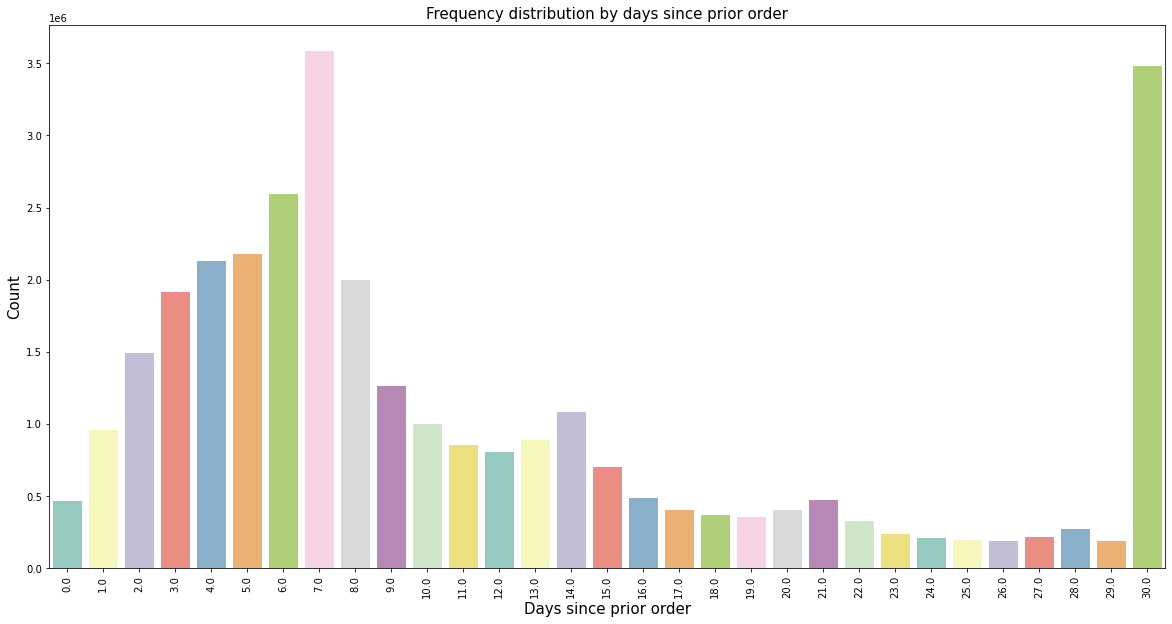

In [40]:
plt.figure(figsize = (20, 10))
sns.countplot(x = 'days_since_prior_order', data = df, palette = 'Set3')

plt.title('Frequency distribution by days since prior order', fontsize=15)
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Days since prior order', fontsize = 15)
plt.xticks(rotation='vertical');

C:\Users\Manal\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


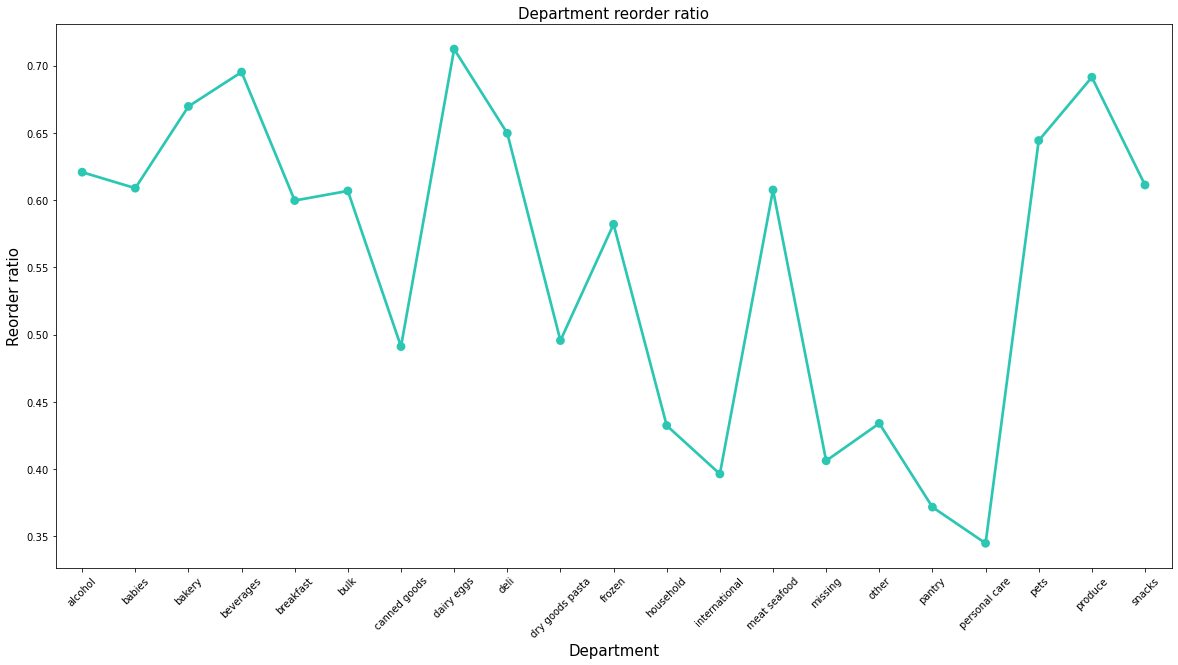

In [41]:
grouped_df = df.groupby(['department'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(20, 10))

sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, color = '#2BC7B3')

plt.title('Department reorder ratio', fontsize = 15)
plt.ylabel('Reorder ratio', fontsize = 15)
plt.xlabel('Department', fontsize = 15)
plt.xticks(rotation = 45);

### Feature Engineering

In [42]:
print('There are', len(list(df._get_numeric_data().columns)), 'Numerical features')

There are 7 Numerical features


In [43]:
print('There are', len(df.select_dtypes('object').columns), 'Categorical features')

There are 4 Categorical features


### Encoding Categorical columns

In [44]:
df['order_dow'] = df['order_dow'].astype('category').cat.codes
df['product_name'] = df['product_name'].astype('category').cat.codes
df['department'] = df['department'].astype('category').cat.codes
df['aisle'] = df['aisle'].astype('category').cat.codes

In [45]:
df.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,add_to_cart_order,reordered,department,aisle
0,202279,2,3,0,9,8.0,29745,1,1,7,41
1,202279,2,3,0,9,8.0,25219,2,1,19,53
2,202279,2,3,0,9,8.0,16729,3,0,16,122
3,202279,2,3,0,9,8.0,9811,4,1,16,89
4,202279,2,3,0,9,8.0,27087,5,0,16,6


In [46]:
#Due to time consumption, we've chose 1% of data
data = df.sample(frac = 0.01, replace = True, random_state = 1)

In [47]:
#View the shape of the sample
data.shape

(317410, 11)

In [48]:
#Check balancing of our target 

data['reordered'].value_counts()

1    199653
0    117757
Name: reordered, dtype: int64

In [49]:
print('percentage of class 1 is :', round((3989044 / 6348208 )* 100), '%')
print('percentage of class 0 is :', round((2359164 / 6348208 )* 100), '%')

percentage of class 1 is : 63 %
percentage of class 0 is : 37 %


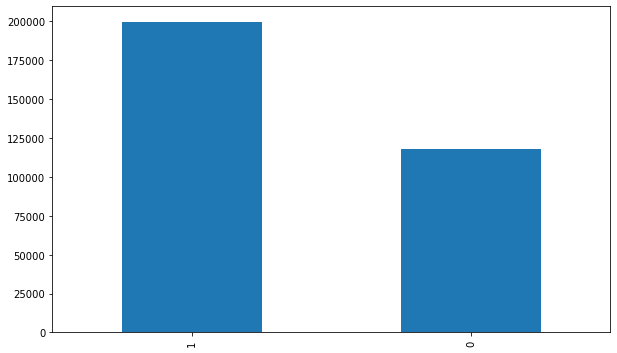

In [50]:
plt.figure(figsize =(10,6))
data['reordered'].value_counts().plot(kind = 'bar');

## Model Building 
 ### before sampling

In [51]:
#Defining Independent & Dependent variables
x = data.drop('reordered',axis = 1)
y = data.reordered

In [52]:
x

,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,add_to_cart_order,department,aisle
13466137,195191,3206551,3,2,15,19.0,18081,3,7,41
22827705,158121,3017739,5,3,13,10.0,17614,1,2,11
7192957,199880,2397223,14,4,19,2.0,32453,2,7,83
13055757,28928,3395617,18,2,21,14.0,26508,7,20,32
524496,116552,745137,9,3,20,6.0,25184,5,12,78
...,...,...,...,...,...,...,...,...,...,...
18890520,42394,1600301,6,4,0,30.0,3012,11,19,53
19156281,113004,1876969,4,2,15,30.0,24033,7,9,74
29480737,204622,3073653,42,4,16,3.0,36695,2,3,131
20189377,54463,2940366,47,2,12,2.0,1930,1,3,110


In [53]:
y

13466137    1
22827705    0
7192957     1
13055757    1
524496      0
           ..
18890520    0
19156281    0
29480737    1
20189377    0
28409145    0
Name: reordered, Length: 317410, dtype: int64

In [54]:
#Feature scaling
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [55]:
#Split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 123)

In [56]:
def accuracy(actuals, preds) :
    acc = metrics.accuracy_score(actuals, preds)
    acc *= 100
    return acc

def precision(actuals, preds) :
    prec = metrics.precision_score(actuals, preds)
    prec *= 100
    return prec

def recall(actuals, preds) :
    rec = metrics.recall_score(actuals, preds)
    rec *= 100
    return rec

def F1(actuals, preds) :
    f1_score = metrics.f1_score(actuals, preds)
    f1_score *= 100
    return f1_score

def confusion_matrix_ (actuals, preds) :
    cf_matrix = metrics.confusion_matrix(actuals, preds)
    return cf_matrix

### KNN Model

In [57]:
#Instantiate
knn = KNeighborsClassifier(n_neighbors = 5)

In [58]:
#Fit
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [59]:
#Predict
y_pred_k = knn.predict(x_test)

In [60]:
print('KNN Model : \n')
print('Accuracy = ', accuracy(y_test, y_pred_k))
print('Precision = ', precision(y_test, y_pred_k))
print('Recall = ', recall(y_test, y_pred_k))
print('F1 = ', F1(y_test, y_pred_k))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_k))

KNN Model : 

Accuracy =  64.22923033300778
Precision =  68.84904636946037
Recall =  78.56533449319973
F1 =  73.38698335807484


Confusion Matrix :
 [[14197 21249]
 [12813 46964]]


In [61]:
knn_repo = classification_report(y_test, y_pred_k, output_dict = True)

In [62]:
KNN = pd.DataFrame(knn_repo).transpose()

In [63]:
KNN

,precision,recall,f1-score,support
0,0.525620,0.400525,0.454624,35446.000000
1,0.688490,0.785653,0.733870,59777.000000
accuracy,0.642292,0.642292,0.642292,0.642292
macro avg,0.607055,0.593089,0.594247,95223.000000
weighted avg,0.627863,0.642292,0.629923,95223.000000


### Logistic Regression Model

In [64]:
lr = LogisticRegression()

In [65]:
lr.fit(x_train, y_train)

LogisticRegression()

In [66]:
y_pred_lr = lr.predict(x_test)

In [67]:
print('Logistic Regression Model : \n')
print('Accuracy = ', accuracy(y_test, y_pred_lr))
print('Precision = ', precision(y_test, y_pred_lr))
print('Recall = ', recall(y_test, y_pred_lr))
print('F1 = ', F1(y_test, y_pred_lr))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_lr))

Logistic Regression Model : 

Accuracy =  67.29571637104482
Precision =  67.95815721148419
Recall =  90.63853990665307
F1 =  77.67662575983483


Confusion Matrix :
 [[ 9900 25546]
 [ 5596 54181]]


In [68]:
lr_repo = classification_report(y_test, y_pred_lr, output_dict = True)

In [69]:
LR = pd.DataFrame(lr_repo).transpose()

In [70]:
LR

,precision,recall,f1-score,support
0,0.638875,0.279298,0.388677,35446.000000
1,0.679582,0.906385,0.776766,59777.000000
accuracy,0.672957,0.672957,0.672957,0.672957
macro avg,0.659228,0.592842,0.582722,95223.000000
weighted avg,0.664429,0.672957,0.632303,95223.000000


### Decision Tree Model

In [71]:
dtree = DecisionTreeClassifier()

In [72]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier()

In [73]:
y_pred_t = dtree.predict(x_test)

In [74]:
print('Decision Tree Model : \n')
print('Accuracy = ', accuracy(y_test, y_pred_t))
print('Precision = ', precision(y_test, y_pred_t))
print('Recall = ', recall(y_test, y_pred_t))
print('F1 = ', F1(y_test, y_pred_t))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test,  y_pred_t))

Decision Tree Model : 

Accuracy =  61.96402129737564
Precision =  69.9820180498066
Recall =  69.01149271458922
F1 =  69.49336702463677


Confusion Matrix :
 [[17751 17695]
 [18524 41253]]


In [75]:
dtree_repo = classification_report(y_test, y_pred_t, output_dict = True)

In [76]:
DTREE = pd.DataFrame(dtree_repo).transpose()

In [77]:
DTREE

,precision,recall,f1-score,support
0,0.489345,0.500790,0.495001,35446.00000
1,0.699820,0.690115,0.694934,59777.00000
accuracy,0.619640,0.619640,0.619640,0.61964
macro avg,0.594583,0.595452,0.594968,95223.00000
weighted avg,0.621473,0.619640,0.620511,95223.00000


### Random Forest Model 

In [78]:
rf = RandomForestClassifier()

In [79]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [80]:
y_pred_rf = rf.predict(x_test)

In [81]:
print('Random Forest Model : \n')
print('Accuracy = ', accuracy(y_test, y_pred_rf))
print('Precision = ', precision(y_test, y_pred_rf))
print('Recall = ', recall(y_test, y_pred_rf))
print('F1 = ', F1(y_test, y_pred_rf))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_rf))

Random Forest Model : 

Accuracy =  70.91879062831458
Precision =  73.30573109609936
Recall =  84.41373772521203
F1 =  78.46857213945822


Confusion Matrix :
 [[17071 18375]
 [ 9317 50460]]


In [82]:
rf_repo = classification_report(y_test, y_pred_rf, output_dict = True)

In [83]:
RF = pd.DataFrame(rf_repo).transpose()

In [84]:
RF

,precision,recall,f1-score,support
0,0.646923,0.481606,0.552156,35446.000000
1,0.733057,0.844137,0.784686,59777.000000
accuracy,0.709188,0.709188,0.709188,0.709188
macro avg,0.689990,0.662872,0.668421,95223.000000
weighted avg,0.700994,0.709188,0.698128,95223.000000


## ROC & AUC

In [85]:
ypred_prob_knn = knn.predict_proba(x_test)
ypred_prob_lr = lr.predict_proba(x_test)
ypred_prob_dtree = dtree.predict_proba(x_test)
ypred_prob_rf = rf.predict_proba(x_test)

In [86]:
class1_probs = ypred_prob_knn[:, 1]
class2_probs = ypred_prob_lr[:, 1]
class3_probs = ypred_prob_dtree[:, 1]
class4_probs = ypred_prob_rf[:, 1]

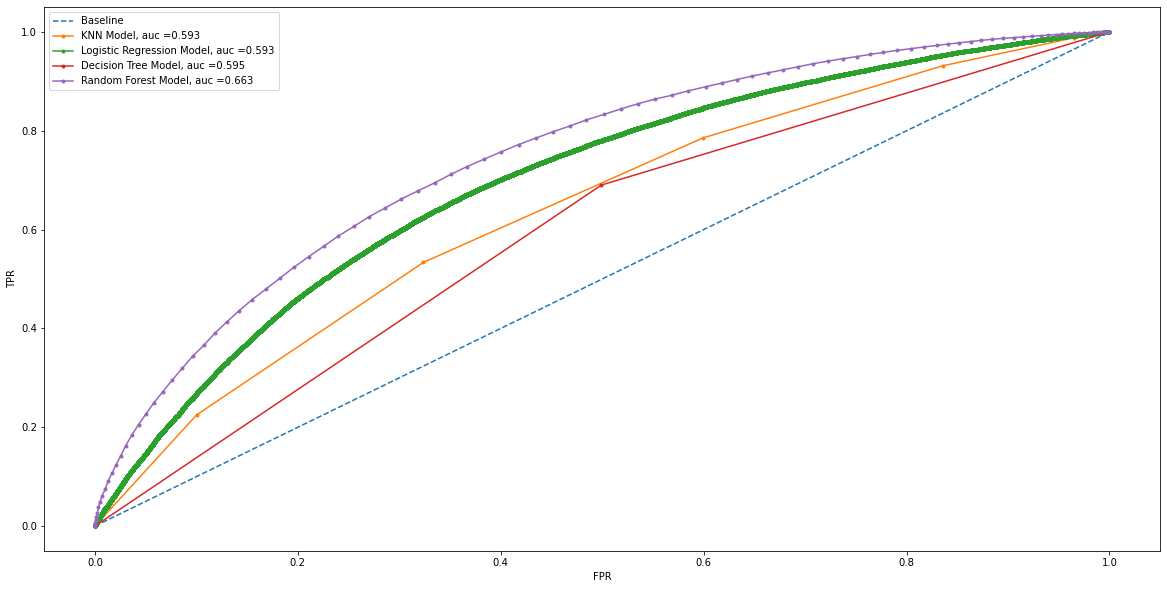

In [87]:
plt.figure(figsize = (20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Baseline')

fpr, tpr, _ = roc_curve(y_test, class1_probs)
fpr1, tpr1, _ = roc_curve(y_test, class2_probs)
fpr2, tpr2, _ = roc_curve(y_test, class3_probs)
fpr3, tpr3, _ = roc_curve(y_test, class4_probs)

auc1 = round(metrics.roc_auc_score(y_test, y_pred_k,average = None),3)
plt.plot(fpr, tpr, marker='.', label=('KNN Model, auc ='+str(auc1)))

auc2 = round(metrics.roc_auc_score(y_test, y_pred_lr,average = None),3)
plt.plot(fpr1, tpr1, marker='.', label=('Logistic Regression Model, auc ='+str(auc2)))

auc3 = round(metrics.roc_auc_score(y_test, y_pred_t,average = None),3)
plt.plot(fpr2, tpr2, marker='.', label=('Decision Tree Model, auc ='+str(auc3)))

auc4 = round(metrics.roc_auc_score(y_test, y_pred_rf,average = None),3)
plt.plot(fpr3, tpr3, marker='.', label=('Random Forest Model, auc ='+str(auc4)))


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

# Dealing with Imbalanced data

## 1- SMOTE Method

In [88]:
sm = SMOTE(random_state = 123)

In [89]:
X_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [90]:
len(X_train_sm), len(y_train_sm)

(279752, 279752)

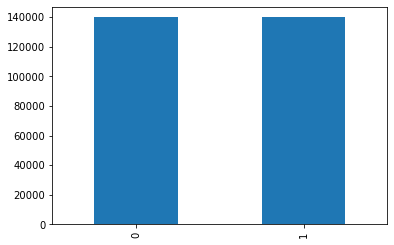

In [91]:
pd.Series(y_train_sm).value_counts().plot.bar();

### 2- Oversampling method

In [92]:
os = RandomOverSampler(sampling_strategy = 'minority')

In [93]:
X_train_os, y_train_os = os.fit_resample(x_train, y_train)

In [94]:
len(X_train_os), len(y_train_os)

(279752, 279752)

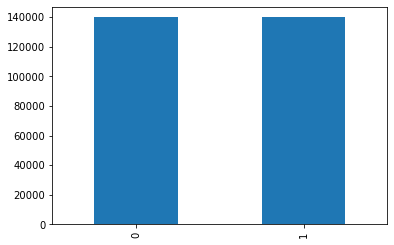

In [95]:
pd.Series(y_train_os).value_counts().plot.bar();

### KNN Model - SMOTE

In [96]:
#Instantiate
knn_sm = KNeighborsClassifier(n_neighbors = 5)

In [97]:
#Fit
knn_sm.fit(X_train_sm, y_train_sm)

KNeighborsClassifier()

In [98]:
#Predict
y_pred_k_sm = knn_sm.predict(x_test)

In [99]:
print('KNN Model - SMOTE : \n')
print('Accuracy = ', accuracy(y_test, y_pred_k_sm))
print('Precision = ', precision(y_test, y_pred_k_sm))
print('Recall = ', recall(y_test, y_pred_k_sm))
print('F1 = ', F1(y_test, y_pred_k_sm))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_k_sm))

KNN Model - SMOTE : 

Accuracy =  60.567299917036856
Precision =  71.25210341135077
Recall =  62.33501179383375
F1 =  66.49594460753259


Confusion Matrix :
 [[20412 15034]
 [22515 37262]]


In [100]:
knn_sm_repo = classification_report(y_test, y_pred_k_sm, output_dict = True)

In [101]:
KNN_SM = pd.DataFrame(knn_sm_repo).transpose()

In [102]:
KNN_SM

,precision,recall,f1-score,support
0,0.475505,0.575862,0.520894,35446.000000
1,0.712521,0.623350,0.664959,59777.000000
accuracy,0.605673,0.605673,0.605673,0.605673
macro avg,0.594013,0.599606,0.592927,95223.000000
weighted avg,0.624294,0.605673,0.611332,95223.000000


### Logistic Regression Model - SMOTE

In [103]:
lr_sm = LogisticRegression(solver = 'lbfgs')

In [104]:
lr_sm.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [105]:
y_pred_lr_sm = lr_sm.predict(x_test)

In [106]:
print('Logistic Regression Model - SMOTE : \n')
print('Accuracy = ', accuracy(y_test, y_pred_lr_sm))
print('Precision = ', precision(y_test, y_pred_lr_sm))
print('Recall = ', recall(y_test, y_pred_lr_sm))
print('F1 = ', F1(y_test, y_pred_lr_sm))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_lr_sm))

Logistic Regression Model - SMOTE : 

Accuracy =  62.31162639278326
Precision =  77.73082905764632
Recall =  56.009836559211735
F1 =  65.1064657267866


Confusion Matrix :
 [[25854  9592]
 [26296 33481]]


In [107]:
lr_sm_repo = classification_report(y_test, y_pred_lr_sm, output_dict = True)

In [108]:
LR_SM = pd.DataFrame(lr_sm_repo).transpose()

In [109]:
LR_SM

,precision,recall,f1-score,support
0,0.495762,0.729391,0.590301,35446.000000
1,0.777308,0.560098,0.651065,59777.000000
accuracy,0.623116,0.623116,0.623116,0.623116
macro avg,0.636535,0.644745,0.620683,95223.000000
weighted avg,0.672505,0.623116,0.628446,95223.000000


### Decision Tree Model - SMOTE

In [110]:
dtree_sm = DecisionTreeClassifier()

In [111]:
dtree_sm.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

In [112]:
y_pred_t_sm = dtree_sm.predict(x_test)

In [113]:
print('Decision Tree Model - SMOTE : \n')
print('Accuracy = ', accuracy(y_test, y_pred_t_sm))
print('Precision = ', precision(y_test, y_pred_t_sm))
print('Recall = ', recall(y_test, y_pred_t_sm))
print('F1 = ', F1(y_test, y_pred_t_sm))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test,  y_pred_t_sm))

Decision Tree Model - SMOTE : 

Accuracy =  61.441038404587125
Precision =  69.58020582141765
Recall =  68.54308513307794
F1 =  69.05775178446525


Confusion Matrix :
 [[17533 17913]
 [18804 40973]]


In [114]:
dtree_sm_repo = classification_report(y_test, y_pred_t_sm, output_dict = True)

In [115]:
DTREE_SM = pd.DataFrame(dtree_sm_repo).transpose()

In [116]:
DTREE_SM

,precision,recall,f1-score,support
0,0.482511,0.494640,0.488500,35446.00000
1,0.695802,0.685431,0.690578,59777.00000
accuracy,0.614410,0.614410,0.614410,0.61441
macro avg,0.589156,0.590035,0.589539,95223.00000
weighted avg,0.616406,0.614410,0.615356,95223.00000


### Random Forest Model - SMOTE

In [117]:
rf_sm = RandomForestClassifier()

In [118]:
rf_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [119]:
y_pred_rf_sm = rf_sm.predict(x_test)

In [120]:
print('Random Forest Model - SMOTE : \n')
print('Accuracy = ', accuracy(y_test, y_pred_rf_sm))
print('Precision = ', precision(y_test, y_pred_rf_sm))
print('Recall = ', recall(y_test, y_pred_rf_sm))
print('F1 = ', F1(y_test, y_pred_rf_sm))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_rf_sm))

Random Forest Model - SMOTE : 

Accuracy =  70.49032271615052
Precision =  74.16652680083614
Recall =  81.31555615035883
F1 =  77.57668613744455


Confusion Matrix :
 [[18515 16931]
 [11169 48608]]


In [121]:
rf_sm_repo = classification_report(y_test, y_pred_rf_sm, output_dict = True)

In [122]:
RF_SM = pd.DataFrame(rf_sm_repo).transpose()

In [123]:
RF_SM

,precision,recall,f1-score,support
0,0.623737,0.522344,0.568555,35446.000000
1,0.741665,0.813156,0.775767,59777.000000
accuracy,0.704903,0.704903,0.704903,0.704903
macro avg,0.682701,0.667750,0.672161,95223.000000
weighted avg,0.697767,0.704903,0.698634,95223.000000


## ROC & AUC - SMOTE

In [124]:
ypred_prob_knn_sm = knn_sm.predict_proba(x_test)
ypred_prob_lr_sm = lr_sm.predict_proba(x_test)
ypred_prob_dtree_sm = dtree_sm.predict_proba(x_test)
ypred_prob_rf_sm = rf_sm.predict_proba(x_test)

In [125]:
class1_probs_sm = ypred_prob_knn_sm[:, 1]
class2_probs_sm = ypred_prob_lr_sm[:, 1]
class3_probs_sm = ypred_prob_dtree_sm[:, 1]
class4_probs_sm = ypred_prob_rf_sm[:, 1]

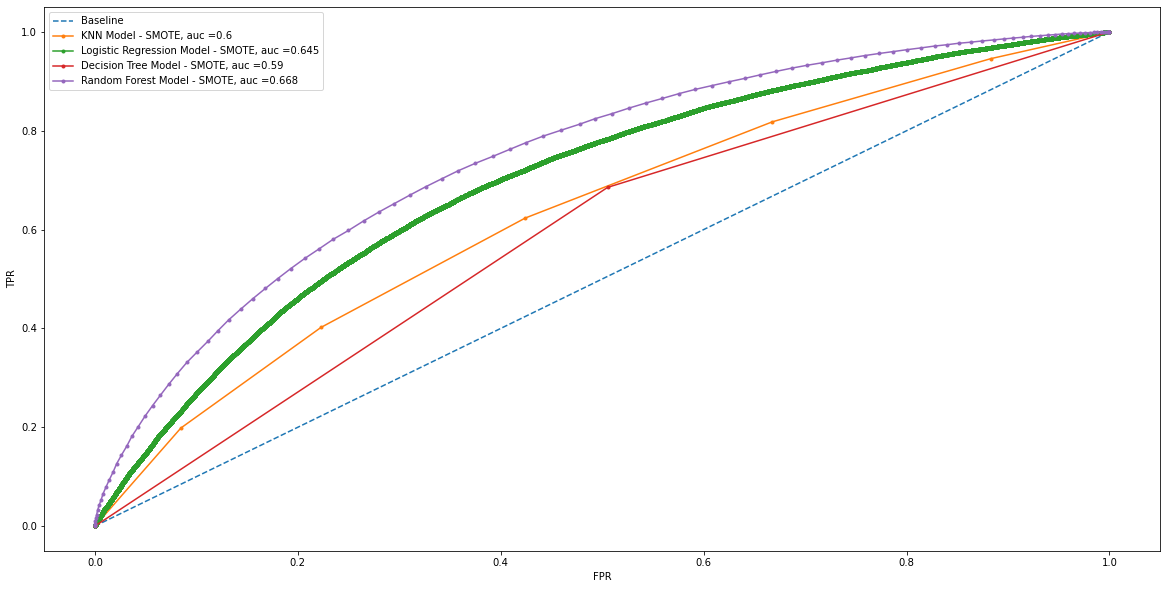

In [126]:
plt.figure(figsize = (20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Baseline')

fpr, tpr, _ = roc_curve(y_test, class1_probs_sm)
fpr1, tpr1, _ = roc_curve(y_test, class2_probs_sm)
fpr2, tpr2, _ = roc_curve(y_test, class3_probs_sm)
fpr3, tpr3, _ = roc_curve(y_test, class4_probs_sm)


auc1 = round(metrics.roc_auc_score(y_test, y_pred_k_sm,average = None),3)
plt.plot(fpr, tpr, marker='.', label=('KNN Model - SMOTE, auc ='+str(auc1)))

auc2 = round(metrics.roc_auc_score(y_test, y_pred_lr_sm,average = None),3)
plt.plot(fpr1, tpr1, marker='.', label=('Logistic Regression Model - SMOTE, auc ='+str(auc2)))

auc3 = round(metrics.roc_auc_score(y_test, y_pred_t_sm,average = None),3)
plt.plot(fpr2, tpr2, marker='.', label=('Decision Tree Model - SMOTE, auc ='+str(auc3)))

auc4 = round(metrics.roc_auc_score(y_test, y_pred_rf_sm,average = None),3)
plt.plot(fpr3, tpr3, marker='.', label=('Random Forest Model - SMOTE, auc ='+str(auc4)))



plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

### KNN Model - Oversampling

In [127]:
#Instantiate
knn_os = KNeighborsClassifier(n_neighbors = 5)

In [128]:
#Fit
knn_os.fit(X_train_os, y_train_os)

KNeighborsClassifier()

In [129]:
#Predict
y_pred_k_os = knn_os.predict(x_test)

In [130]:
print('KNN Model - Oversampling : \n')
print('Accuracy = ', accuracy(y_test, y_pred_k_os))
print('Precision = ', precision(y_test, y_pred_k_os))
print('Recall = ', recall(y_test, y_pred_k_os))
print('F1 = ', F1(y_test, y_pred_k_os))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_k_os))

KNN Model - Oversampling : 

Accuracy =  60.47278493641242
Precision =  70.71915244085055
Recall =  63.20323870384931
F1 =  66.75029372532045


Confusion Matrix :
 [[19803 15643]
 [21996 37781]]


In [131]:
knn_os_repo = classification_report(y_test, y_pred_k_os, output_dict = True)

In [132]:
KNN_OS = pd.DataFrame(knn_os_repo).transpose()

In [133]:
KNN_OS

,precision,recall,f1-score,support
0,0.473767,0.558681,0.512732,35446.000000
1,0.707192,0.632032,0.667503,59777.000000
accuracy,0.604728,0.604728,0.604728,0.604728
macro avg,0.590479,0.595357,0.590118,95223.000000
weighted avg,0.620301,0.604728,0.609891,95223.000000


### Logistic Regression Model - Oversampling

In [134]:
lr_os = LogisticRegression(solver = 'lbfgs')

In [135]:
lr_os.fit(X_train_os, y_train_os)

LogisticRegression()

In [136]:
y_pred_lr_os = lr_os.predict(x_test)

In [137]:
print('Logistic Regression Model - Oversampling : \n')
print('Accuracy = ', accuracy(y_test, y_pred_lr_os))
print('Precision = ', precision(y_test, y_pred_lr_os))
print('Recall = ', recall(y_test, y_pred_lr_os))
print('F1 = ', F1(y_test, y_pred_lr_os))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_lr_os))

Logistic Regression Model - Oversampling : 

Accuracy =  62.39984037469939
Precision =  77.63713080168776
Recall =  56.329357445171226
F1 =  65.28871136619227


Confusion Matrix :
 [[25747  9699]
 [26105 33672]]


In [138]:
lr_os_repo = classification_report(y_test, y_pred_lr_os, output_dict = True)

In [139]:
LR_OS = pd.DataFrame(lr_os_repo).transpose()

In [140]:
LR_OS

,precision,recall,f1-score,support
0,0.496548,0.726373,0.589865,35446.000000
1,0.776371,0.563294,0.652887,59777.000000
accuracy,0.623998,0.623998,0.623998,0.623998
macro avg,0.636460,0.644833,0.621376,95223.000000
weighted avg,0.672209,0.623998,0.629427,95223.000000


### Decision Tree Model - Oversampling

In [141]:
dtree_os = DecisionTreeClassifier()

In [142]:
dtree_os.fit(X_train_os, y_train_os)

DecisionTreeClassifier()

In [143]:
y_pred_t_os = dtree_os.predict(x_test) 

In [144]:
print('Decision Tree Model - Oversampling : \n')
print('Accuracy = ', accuracy(y_test, y_pred_t_os))
print('Precision = ', precision(y_test, y_pred_t_os))
print('Recall = ', recall(y_test, y_pred_t_os))
print('F1 = ', F1(y_test, y_pred_t_os))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test,  y_pred_t_os))

Decision Tree Model - Oversampling : 

Accuracy =  61.87475714900812
Precision =  69.63380564431135
Recall =  69.63380564431135
F1 =  69.63380564431135


Confusion Matrix :
 [[17294 18152]
 [18152 41625]]


In [145]:
dtree_os_repo = classification_report(y_test, y_pred_t_os, output_dict = True)

In [146]:
DTREE_OS = pd.DataFrame(dtree_os_repo).transpose()

In [147]:
DTREE_OS

,precision,recall,f1-score,support
0,0.487897,0.487897,0.487897,35446.000000
1,0.696338,0.696338,0.696338,59777.000000
accuracy,0.618748,0.618748,0.618748,0.618748
macro avg,0.592118,0.592118,0.592118,95223.000000
weighted avg,0.618748,0.618748,0.618748,95223.000000


### Random Forest Model - Oversampling

In [148]:
rf_os = RandomForestClassifier()

In [149]:
rf_os.fit(X_train_os, y_train_os)

RandomForestClassifier()

In [150]:
y_pred_rf_os = rf_os.predict(x_test)

In [151]:
print('Random Forest Model - Oversampling : \n')
print('Accuracy = ', accuracy(y_test, y_pred_rf_os))
print('Precision = ', precision(y_test, y_pred_rf_os))
print('Recall = ', recall(y_test, y_pred_rf_os))
print('F1 = ', F1(y_test, y_pred_rf_os))
print('\n')
print('Confusion Matrix :\n', confusion_matrix_(y_test, y_pred_rf_os))

Random Forest Model - Oversampling : 

Accuracy =  70.53127920775442
Precision =  74.67940737051792
Recall =  80.27502216571591
F1 =  77.3761821450743


Confusion Matrix :
 [[19176 16270]
 [11791 47986]]


In [152]:
rf_os_repo = classification_report(y_test, y_pred_rf_os, output_dict = True)

In [153]:
RF_OS = pd.DataFrame(rf_os_repo).transpose()

In [154]:
RF_OS

,precision,recall,f1-score,support
0,0.619240,0.540992,0.577477,35446.000000
1,0.746794,0.802750,0.773762,59777.000000
accuracy,0.705313,0.705313,0.705313,0.705313
macro avg,0.683017,0.671871,0.675620,95223.000000
weighted avg,0.699313,0.705313,0.700696,95223.000000


## ROC & AUC - Oversampling

In [155]:
ypred_prob_knn_os = knn_os.predict_proba(x_test)
ypred_prob_lr_os = lr_os.predict_proba(x_test)
ypred_prob_dtree_os = dtree_os.predict_proba(x_test)
ypred_prob_rf_os = rf_os.predict_proba(x_test)

In [156]:
class1_probs_os = ypred_prob_knn_os[:, 1]
class2_probs_os = ypred_prob_lr_os[:, 1]
class3_probs_os = ypred_prob_dtree_os[:, 1]
class4_probs_os = ypred_prob_rf_os[:, 1]

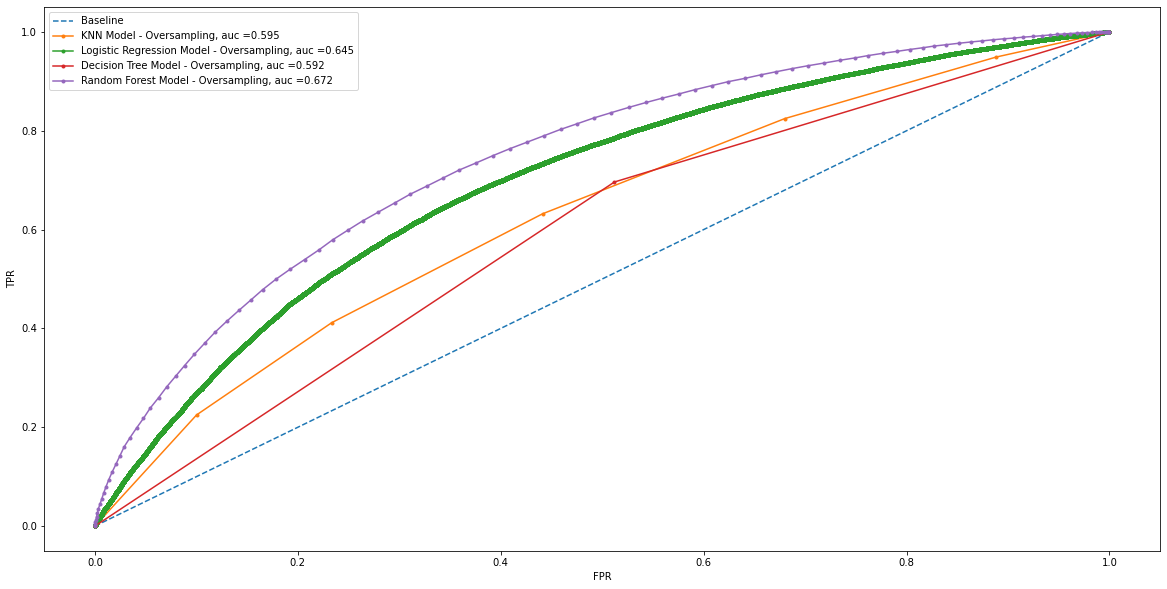

In [157]:
plt.figure(figsize = (20, 10))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Baseline')

fpr, tpr, _ = roc_curve(y_test, class1_probs_os)
fpr1, tpr1, _ = roc_curve(y_test, class2_probs_os)
fpr2, tpr2, _ = roc_curve(y_test, class3_probs_os)
fpr3, tpr3, _ = roc_curve(y_test, class4_probs_os)


auc1 = round(metrics.roc_auc_score(y_test, y_pred_k_os,average = None),3)
plt.plot(fpr, tpr, marker='.', label=('KNN Model - Oversampling, auc ='+str(auc1)))

auc2 = round(metrics.roc_auc_score(y_test, y_pred_lr_os,average = None),3)
plt.plot(fpr1, tpr1, marker='.', label=('Logistic Regression Model - Oversampling, auc ='+str(auc2)))

auc3 = round(metrics.roc_auc_score(y_test, y_pred_t_os,average = None),3)
plt.plot(fpr2, tpr2, marker='.', label=('Decision Tree Model - Oversampling, auc ='+str(auc3)))

auc4 = round(metrics.roc_auc_score(y_test, y_pred_rf_os,average = None),3)
plt.plot(fpr3, tpr3, marker='.', label=('Random Forest Model - Oversampling, auc ='+str(auc4)))



plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();